<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/UrbanSound8K-Audio-Classification-EfficientNet/UrbanSound_ConvNet_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
chrisfilo_urbansound8k_path = kagglehub.dataset_download('chrisfilo/urbansound8k')

print('Data source import complete.')

Using Colab cache for faster access to the 'urbansound8k' dataset.
Data source import complete.


# Imports

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             roc_curve, auc)

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D,
                                     Conv2D, MaxPooling2D, Flatten,
                                     Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Configuration

In [ ]:
# Paths based on the Kaggle input structure
BASE_PATH = '/kaggle/input/urbansound8k'
METADATA_PATH = os.path.join(BASE_PATH, 'UrbanSound8K.csv')

# Audio settings
SAMPLE_RATE = 22050
DURATION = 4  # Duration in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

# Image settings for EfficientNet
IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3  # RGB
BATCH_SIZE = 32
EPOCHS = 15
NUM_CLASSES = 10
TEST_FOLD = 10

# Set to None to load the full dataset (takes longer)
# Set to an integer (e.g., 2000) for debugging/fast testing
DATA_LIMIT = None

# Helper Functions

In [ ]:
def get_spectrogram(file_path, augment=False):
    try:
        y, sr = librosa.load(file_path, sr=22050)

        # Handle audio length
        max_len = 22050 * 4
        if len(y) > max_len:
            y = y[:max_len]
        else:
            y = np.pad(y, (0, max_len - len(y)), mode='constant')

        if augment:
            noise_amp = 0.005 * np.random.uniform() * np.amax(y)
            y = y + noise_amp * np.random.normal(size=y.shape[0])

        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        img = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())

        # Resize to fixed dimensions
        img = cv2.resize(img, (128, 128)) # Note: tuple (128, 128)

        # Convert to 3 channels
        img = np.stack((img,) * 3, axis=-1)

        # Ensure data type
        return img.astype(np.float32)

    except Exception as e:
        print(f"Error: {e}")
        return None

# Data Pipeline

In [13]:
def load_data_by_folds(metadata_path, base_path, test_fold_num):
    # Read the metadata CSV file into a pandas DataFrame
    df = pd.read_csv(metadata_path)

    # Initialize lists to store training and validation data and labels
    train_data, train_labels = [], []
    val_data, val_labels = [], []

    print(f"⏳ Loading Data (Test Fold: {test_fold_num})...")

    # Iterate through each row in the DataFrame to process audio files
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        fold = row['fold']
        # Construct the full file path for the audio file
        file_path = os.path.join(base_path, f"fold{fold}", row['slice_file_name'])
        label = row['classID'] # Use classID directly (0-9) as the label

        # Check if the current fold is the designated test fold
        if fold == test_fold_num:
            # For validation data, do not apply augmentation
            spec = get_spectrogram(file_path, augment=False)
            if spec is not None:
                val_data.append(spec)
                val_labels.append(label)

        else:
            # For training data, apply augmentation
            spec = get_spectrogram(file_path, augment=True)
            if spec is not None:
                train_data.append(spec)
                train_labels.append(label)

    # Convert lists to NumPy arrays before returning
    return (np.array(train_data), np.array(train_labels)), \
           (np.array(val_data), np.array(val_labels)), df

# Load the dataset, splitting into training and validation sets based on the TEST_FOLD
(X_train, y_train_idx), (X_val, y_val_idx), metadata_df = load_data_by_folds(METADATA_PATH, BASE_PATH, TEST_FOLD)

# Initialize and fit LabelEncoder here
label_encoder = LabelEncoder()
label_encoder.fit(metadata_df['class'].unique())

# Convert integer labels to one-hot encoded categorical format for Keras
y_train = to_categorical(y_train_idx, 10)
y_val = to_categorical(y_val_idx, 10)

# Print the shapes of the prepared training and validation datasets
print(f"Train: {X_train.shape}, Val: {X_val.shape}")

⏳ Loading Data (Test Fold: 10)...


100%|██████████| 8732/8732 [06:19<00:00, 23.02it/s]


Train: (7895, 128, 128, 3), Val: (837, 128, 128, 3)


# Model Definition

In [14]:
def build_robust_cnn(input_shape, num_classes):
    model = Sequential([

        # --- Block 1 ---
        # L2 Regularizer limits the weights to prevent overfitting
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(), # Normalizes data for faster training
        MaxPooling2D((2, 2)),
        Dropout(0.3), # 30% dropout rate

        # --- Block 2 ---
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # --- Block 3 ---
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4), # Higher dropout rate in deeper layers

        # --- Classifier Head ---
        Flatten(),

        # Dense layer with more neurons but heavy dropout
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5), # Drops 50% of neurons at each step (strong prevention of overfitting)

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    # Compile settings with Label Smoothing
    # label_smoothing=0.1 means instead of saying the probability is 100%, it says 90%.
    # This prevents the loss from exploding suddenly.
    optimizer = Adam(learning_rate=0.001)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])

    return model

# Build the model
model_robust = build_robust_cnn((IMG_HEIGHT, IMG_WIDTH, CHANNELS), NUM_CLASSES)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Training

In [15]:
# Define Callbacks
callbacks = [
    # Save the best model (only when validation loss decreases)
    ModelCheckpoint(
        'best_simple_cnn.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),

    # Smart Stopping (if no improvement for 7 epochs)
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce Learning Rate (if stuck, decrease speed)
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,       # Reduce learning rate by half
        patience=3,       # If no improvement for 3 epochs
        min_lr=1e-6,
        verbose=1
    )
]

print("Starting Training Simple CNN...")
# Start Training
history = model_robust.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Starting Training Simple CNN...
Epoch 1/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4136 - loss: 2.9203
Epoch 1: val_loss improved from inf to 4.39455, saving model to best_simple_cnn.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - accuracy: 0.4139 - loss: 2.9191 - val_accuracy: 0.1350 - val_loss: 4.3945 - learning_rate: 0.0010
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6778 - loss: 2.2297
Epoch 2: val_loss improved from 4.39455 to 3.59126, saving model to best_simple_cnn.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.6780 - loss: 2.2293 - val_accuracy: 0.2676 - val_loss: 3.5913 - learning_rate: 0.0010
Epoch 3/50
246/247 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7811 - loss: 1.9479
Epoch 3: val_loss did not improve from 3.59126
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7812 - loss: 1.9479 - val_accuracy: 0.5663 - val_loss: 4.6765 - learning_rate: 0.0010
Epoch 4/50
245/247 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - ac

# Evaluation

Making predictions...
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


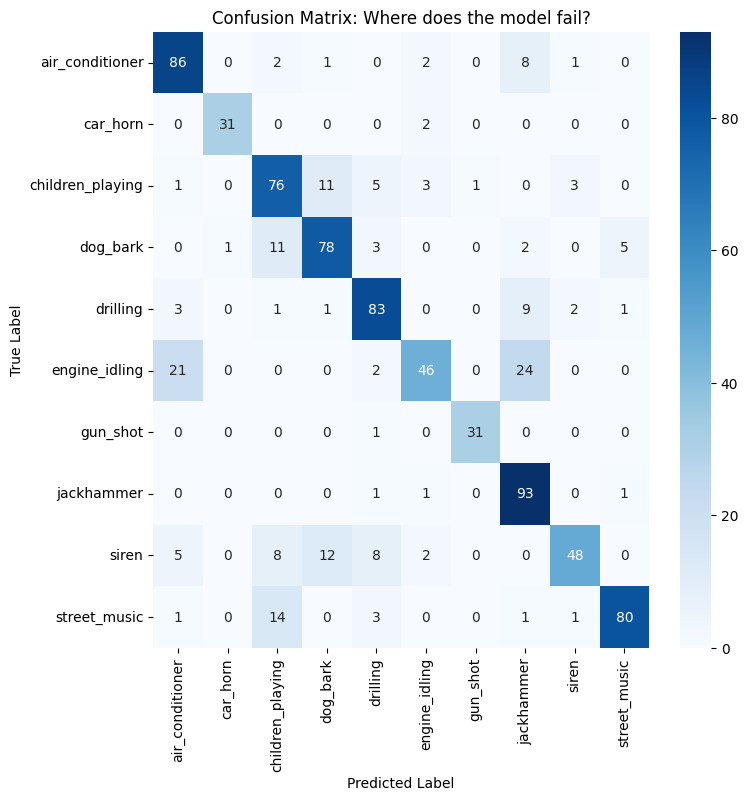


Classification Report:

                  precision    recall  f1-score   support

 air_conditioner       0.74      0.86      0.79       100
        car_horn       0.97      0.94      0.95        33
children_playing       0.68      0.76      0.72       100
        dog_bark       0.76      0.78      0.77       100
        drilling       0.78      0.83      0.81       100
   engine_idling       0.82      0.49      0.62        93
        gun_shot       0.97      0.97      0.97        32
      jackhammer       0.68      0.97      0.80        96
           siren       0.87      0.58      0.70        83
    street_music       0.92      0.80      0.86       100

        accuracy                           0.78       837
       macro avg       0.82      0.80      0.80       837
    weighted avg       0.79      0.78      0.77       837



In [16]:
# Make predictions on the test data
print("Making predictions...")
y_pred = model_robust.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1) # Convert probabilities to class indices
y_true = np.argmax(y_val, axis=1)          # Convert true labels to class indices

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Where does the model fail?')
plt.show()

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

## Prediction Probabilities

In [17]:
# Calculate prediction probabilities
y_pred_probs = model_robust.predict(X_val)

# Calculate Top-1 Accuracy (standard accuracy)
top1 = tf.keras.metrics.top_k_categorical_accuracy(y_val, y_pred_probs, k=1)
print(f"Top-1 Accuracy: {np.mean(top1):.2%}")

# Calculate Top-2 Accuracy (is the correct answer within the top 2 predictions?)
top2 = tf.keras.metrics.top_k_categorical_accuracy(y_val, y_pred_probs, k=2)
print(f"Top-2 Accuracy: {np.mean(top2):.2%}")

# Calculate Top-3 Accuracy
top3 = tf.keras.metrics.top_k_categorical_accuracy(y_val, y_pred_probs, k=3)
print(f"Top-3 Accuracy: {np.mean(top3):.2%}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Top-1 Accuracy: 77.90%
Top-2 Accuracy: 88.77%
Top-3 Accuracy: 93.07%


## AUC-ROC Plot

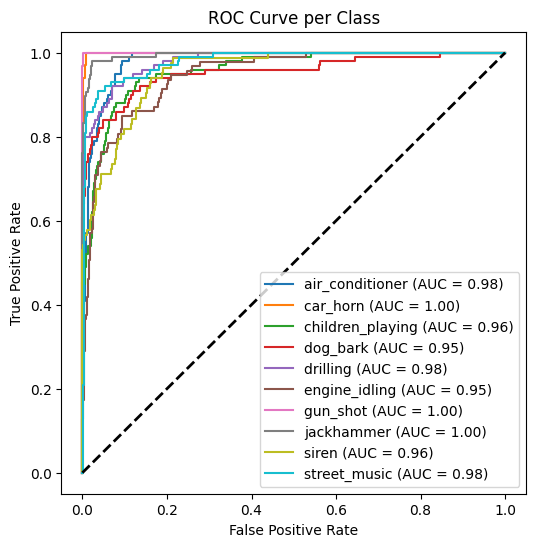

In [18]:
# Plot settings
plt.figure(figsize=(6, 6))
classes = label_encoder.classes_

# Plot ROC curve for each class
for i in range(len(classes)):
    # Calculate ROC for class i against the rest
    fpr, tpr, _ = roc_curve(y_val[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Line of chance (50-50)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class')
plt.legend(loc="lower right")
plt.show()

## Check Errors

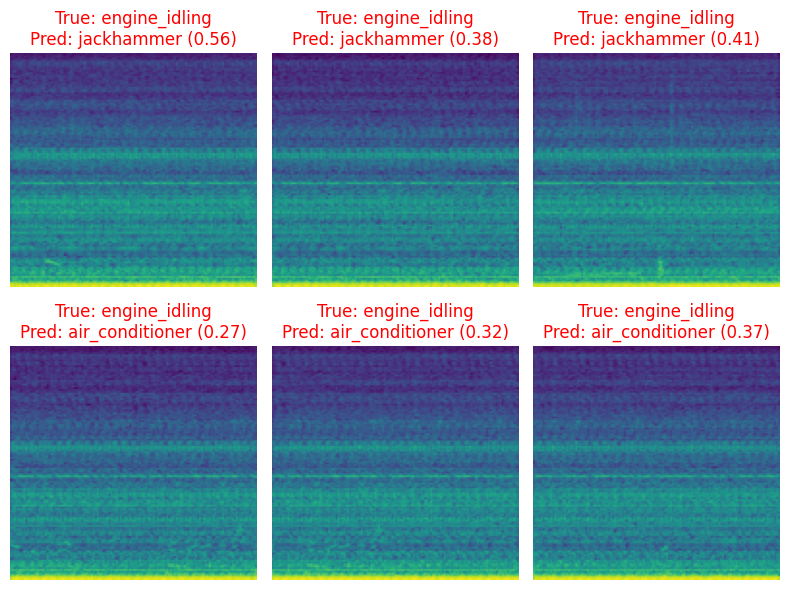

In [19]:
# Find the indices where the model made errors
y_true_cls = np.argmax(y_val, axis=1)
y_pred_cls = np.argmax(y_pred_probs, axis=1)
errors = np.where(y_pred_cls != y_true_cls)[0]

# Display the first 6 errors
plt.figure(figsize=(8, 6))
for i, err_idx in enumerate(errors[:6]):
    plt.subplot(2, 3, i+1)

    # Display the spectrogram image
    # (Since it's normalized and 3-channeled, we display only the first channel)
    plt.imshow(X_val[err_idx][:,:,0], origin='lower', aspect='auto', cmap='viridis')

    true_label = classes[y_true_cls[err_idx]]
    pred_label = classes[y_pred_cls[err_idx]]
    conf = y_pred_probs[err_idx][y_pred_cls[err_idx]]

    plt.title(f"True: {true_label}\nPred: {pred_label} ({conf:.2f})", color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
def test_with_noise(model, X_data, y_data, noise_factor):
    # Copy data to avoid modifying original
    X_noisy = X_data.copy()

    # Add noise
    noise = np.random.normal(0, 1, X_noisy.shape)
    X_noisy = X_noisy + noise_factor * noise

    # Evaluate the model on noisy data
    loss, acc = model.evaluate(X_noisy, y_data, verbose=0)
    return acc

print("Robustness Test:")
print(f"Clean Data Accuracy: {test_with_noise(model_robust, X_val, y_val, 0):.2%}")
print(f"Low Noise (0.05):    {test_with_noise(model_robust, X_val, y_val, 0.05):.2%}")
print(f"Med Noise (0.1):     {test_with_noise(model_robust, X_val, y_val, 0.1):.2%}")
print(f"High Noise (0.2):    {test_with_noise(model_robust, X_val, y_val, 0.2):.2%}")

Robustness Test:
Clean Data Accuracy: 77.90%
Low Noise (0.05):    66.79%
Med Noise (0.1):     31.66%
High Noise (0.2):    12.07%
